<a href="https://colab.research.google.com/githubDeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/Exercise_07_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air-shower reconstruction using a fully-connected network
## Cosmic-ray observatory
In this example, we will train a neural network to reconstruct air-shower properties measured by a hypothetic cosmic-ray observatory located at a height of 1400 m. The observatory features a cartesian array of 14 x 14 particle detectors with a distance of 750 m. 
Thus, the measured data contain the simulated detector responses from secondary particles of the cosmic-ray induced air shower that interact with the ground-based observatory.  

Each particle detector measures two quantities that are stored in the form of a cartesian image (2D array with 14 x 14 pixels)
- arrival time `T`: arrival time of the first particles
- signal `S`: integrated signal

In this task, we are interested in reconstructing the cosmic-ray energy in EeV (exaelectronvolt = $10^{18}~\mathrm{eV}$) using the measured particle footprint and a fully-connected network.


# Preparation:
**Enable a GPU for this task.**  
Therefore, click:
*Edit* -> *Notebook settings* -> *select GPU* as *Hardware accelerator*

# References
The tutorial is inspired by the simulation and the study performed in https://doi.org/10.1016/j.astropartphys.2017.10.006.  


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

layers = keras.layers

print("keras", keras.__version__)
print("tf", tf.__version__)


keras 2.6.0
tf 2.6.0


---
# Data
### Download data
As a first step, we have to download the simulated air shower data.

In [ ]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=19gOSVQ0mhdjMkm5i2u5NsGrWNBdlhR4F"
output = 'airshowers_mnist.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=False)

f = np.load(output)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=19gOSVQ0mhdjMkm5i2u5NsGrWNBdlhR4F
To: /content/airshowers_mnist.npz
100%|██████████| 64.7M/64.7M [00:00<00:00, 175MB/s]


### Input 1: Arrival times
Our first input is the arrival times of the first shower particles, measured at the various stations. We normalize the arrival times with respect to the mean and the standard deviation of the arrival time distribution.  
Remember that each input has the shape of 14 x 14, as each station measures a specific arrival time.


In [ ]:
# time map
T = f['time']
T -= np.nanmean(T)
T /= np.nanstd(T)
T[np.isnan(T)] = 0

print(T.shape)

(100000, 14, 14)


#### Plot four example maps
To visualize a map of arrival times, we can plot a random example event. Here, the dark blue indicates an early trigger and a bright yellow a late trigger.  
With this information, one can directly get an impression of the shower axis (arrival direction) of the arriving particle shower.

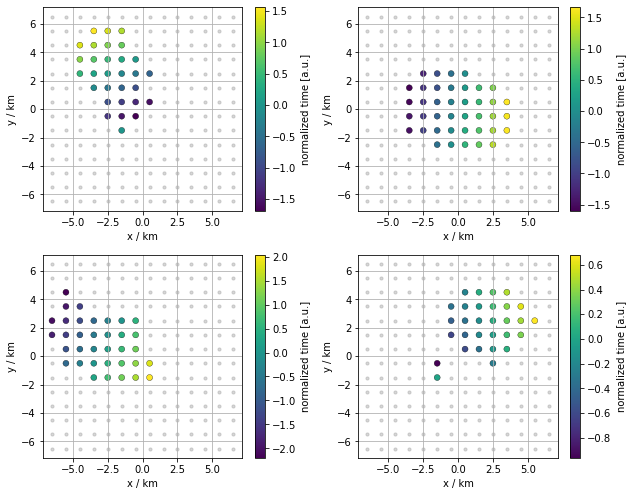

In [ ]:
nsamples=len(T)
random_samples = np.random.choice(nsamples, 4)

def rectangular_array(n=14):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)

plt.figure(figsize=(9,7))

for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=T[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], 
                          cmap="viridis", alpha=1, label="loud",
                          edgecolors="k", linewidths=0.3)
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized time [a.u.]')
    plt.xlabel("x / km")
    plt.ylabel("y / km")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Input 2: Measured signals
In the following, we inspect the measured signals of the detectors. Again, we have 14 x 14 measurements (a few are zero as no signal was measured) that form a single event. We process the signal using a logarithmic re-scaling.


In [ ]:
# signal map
S = f['signal']
S = np.log10(1 + S)
S -= np.nanmin(S)
S /= np.nanmax(S)
S[np.isnan(S)] = 0

print(S.shape)

(100000, 14, 14)


#### Plot four example events

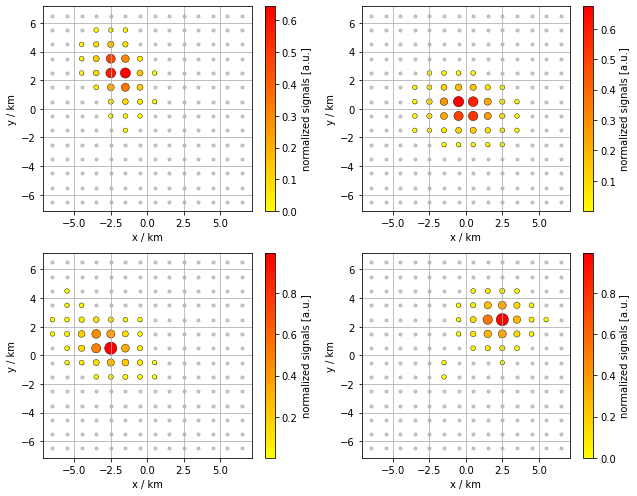

In [ ]:
plt.figure(figsize=(9,7))

for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=S[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 130 * footprint[mask] + 20
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.4, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], s=marker_size,
                          cmap="autumn_r", alpha=1, label="loud",
                          edgecolors="k", linewidths=0.4)
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized signals [a.u.]')
    plt.xlabel("x / km")
    plt.ylabel("y / km")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Labels
Now, we can prepare the targets of our neural network training.

In [ ]:
axis = f['showeraxis']

In [ ]:
core = f['showercore'][:, 0:2]
core /= 750

In [ ]:
# energy - log10(E/eV) in range 3 - 100 EeV
energy = f['energy']
print(energy)

[ 4.00461776  5.99159294  7.49367551 ... 10.81657107  5.07542798
 43.32910954]


---
#### Training and test data
We further split the data into one large training set and a smaller test set. This test set is used for the final evaluation of the model and is only used once to ensure an unbiased performance measure.


Before, we combine our input `X` by concatenating the maps of arrival times with the maps of signals.

In [ ]:
X = np.stack([T, S], axis=-1)

In [ ]:
X_train, X_test = np.split(X, [-20000])
energy_train, energy_test = np.split(energy, [-20000])

---
## Define Model
Now, we will set up a neural network to reconstruct the energy of the particle shower. In this **define step** we will set the architecture of the model.


> **Modification section**  
> Feel free to modify the model.
> For example:
> *   Change the number of nodes (but remember that the number of weights scales with n x n. Also, the final layer has to have only one node as we are reconstructing the energy, which is a scalar.).
> *   Change the activation function, e.g., use `relu, tanh, sigmoid, softplus, elu, ` (take care to not use an activation function for the final layer!).
> *   Add new layers.
> * Increase the Dropout fraction or place Dropout between several layers if you observe overtraining (validation loss increases).




In [ ]:
model = keras.models.Sequential(name="energy_regression_NN")

model.add(layers.Flatten(input_shape=X_train.shape[1:]))  # this layer re-arranges the 2D image to a vector, leave it as it is
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

We can have a deeper look at our designed model and inspect the number of adaptive parameters by printing the model `summary`.

In [ ]:
print(model.summary())

Model: "energy_regression_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                7860      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 7,881
Trainable params: 7,881
Non-trainable params: 0
_________________________________________________________________
None


### Compile
We now compile the model to prepare it for the training. During the **compile** step, we set a loss/objective function (`mean_squared_error`, as energy reconstruction is a regression task) and set an optimizer. In this case, we use the Adam optimizer with a learning rate of 0.001.
To monitor the resolution and the bias of the model, we add them as a metric.

In [ ]:
def resolution(y_true, y_pred):
    """ Metric to control for standart deviation """
    mean, var = tf.nn.moments((y_true - y_pred), axes=[0])
    return tf.sqrt(var)


def bias(y_true, y_pred):
    """ Metric to control for standart deviation """
    mean, var = tf.nn.moments((y_true - y_pred), axes=[0])
    return mean

In [ ]:
model.compile(
    loss='mean_squared_error',
    metrics=[bias, resolution],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3))

---
### Training
We can now run the training for 20 `epochs` (20-fold iteration over the dataset) using our training data `X_train` and our energy labels `energy_train`.
For each iteration (calculating the gradients, updating the model parameters), we use 128 samples (`batch_size`).

We furthermore can set the fraction of validation data (initially set to `0.1`) that is used to monitor overtraining.

> **Modification section**  
> Feel free to modify the training procedure, for example:
>*   Change the number of `epochs`.
>*   Modify the batch size via `batch_size`.


In [ ]:
fit = model.fit(
    X_train,
    energy_train,
    batch_size=128,
    epochs=20,
    verbose=2,
    validation_split=0.1,
)

Epoch 1/20
563/563 - 5s - loss: 746.4584 - bias: 13.0071 - resolution: 22.1177 - val_loss: 352.7163 - val_bias: 1.5808 - val_resolution: 18.5667
Epoch 2/20
563/563 - 1s - loss: 376.1041 - bias: 0.1602 - resolution: 19.2135 - val_loss: 256.1392 - val_bias: -7.3458e-01 - val_resolution: 15.8561
Epoch 3/20
563/563 - 1s - loss: 267.0853 - bias: -4.1491e-01 - resolution: 16.1808 - val_loss: 148.9649 - val_bias: -2.4613e-01 - val_resolution: 12.0982
Epoch 4/20
563/563 - 1s - loss: 205.4026 - bias: 0.1646 - resolution: 14.2148 - val_loss: 115.8402 - val_bias: 0.4933 - val_resolution: 10.6494
Epoch 5/20
563/563 - 1s - loss: 188.3320 - bias: 0.5953 - resolution: 13.5976 - val_loss: 109.1404 - val_bias: 0.5717 - val_resolution: 10.3344
Epoch 6/20
563/563 - 1s - loss: 182.5860 - bias: 0.7448 - resolution: 13.3817 - val_loss: 104.5062 - val_bias: 0.9623 - val_resolution: 10.0730
Epoch 7/20
563/563 - 1s - loss: 177.0771 - bias: 0.8350 - resolution: 13.1740 - val_loss: 99.0709 - val_bias: 0.7959 - v

### Plot training curves

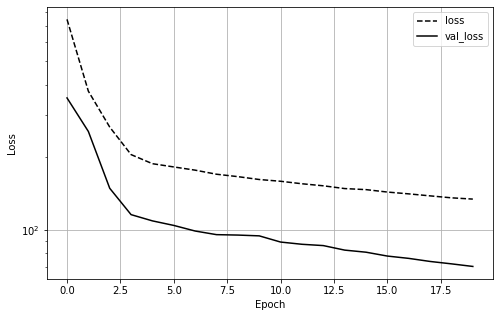

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,5))
n = np.arange(len(fit.history['loss']))

ax.plot(n, fit.history['loss'], ls='--', c='k', label='loss')
ax.plot(n, fit.history['val_loss'], label='val_loss', c='k')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.semilogy()
ax.grid()
plt.show()

---
### Performance of the DNN
After training the model, we can use the test set `X_test` to evaluate the performance of the DNN.  

Particularly interesting are the resolution and the bias of the method. A bias close to 0 is desirable. A resolution below 3 EeV can be regarded as good.

In [ ]:
energy_pred = model.predict(X_test, batch_size=128, verbose=1)[:,0]


157/157 [==============================] - 0s 1ms/step


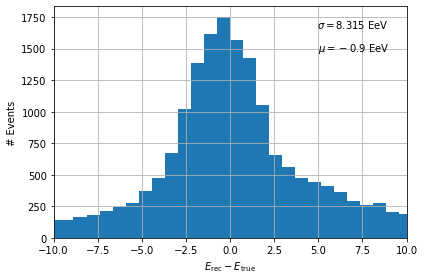

In [ ]:
diff = energy_pred - energy_test
resolution = np.std(diff)
plt.figure()
plt.hist(diff, bins=100)
plt.xlabel('$E_\mathrm{rec} - E_\mathrm{true}$')
plt.ylabel('# Events')
plt.text(0.95, 0.95, '$\sigma = %.3f$ EeV' % resolution, ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.85, '$\mu = %.1f$ EeV' % diff.mean(), ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.xlim(-10, 10)
plt.tight_layout()

After estimating the bias and the resolution, we can now inspect the reconstruction via a scatter plot.  

Furthermore, we can study the energy dependence of the resolution. With increasing energy, the performance increases due to the lower sampling fluctuation of the ground-based particle detectors and the larger footprints.

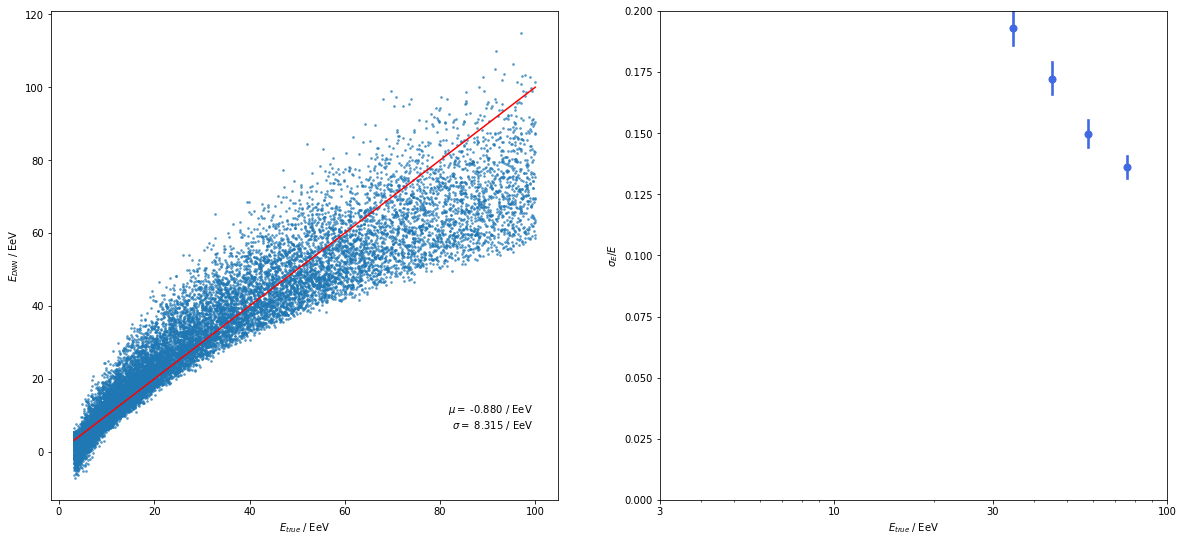

In [ ]:
x = [3, 10, 30, 100]
labels = ["3", "10", "30", "100"]

diff = energy_pred - energy_test

# Embedding plot
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
axes[0].scatter(energy_test, energy_pred, s=3, alpha=0.60)
axes[0].set_xlabel(r"$E_{true}\;/\;\mathrm{EeV}$")
axes[0].set_ylabel(r"$E_{DNN}\;/\;\mathrm{EeV}$")

stat_box = r"$\mu = $ %.3f" % np.mean(diff) + " / EeV" + "\n" + "$\sigma = $ %.3f" % np.std(diff) + " / EeV"
axes[0].text(0.95, 0.2, stat_box, verticalalignment="top", horizontalalignment="right",
          transform=axes[0].transAxes, backgroundcolor="w")
axes[0].plot([np.min(energy_test), np.max(energy_test)],
             [np.min(energy_test), np.max(energy_test)], color="red")

sns.regplot(x=energy_test, y=diff / energy_test, x_estimator=np.std, x_bins=12,
            fit_reg=False, color="royalblue", ax=axes[1])
axes[1].tick_params(axis="both", which="major")
axes[1].set(xscale="log")
plt.xticks(x, labels)

axes[1].set_xlabel(r"$E_{true}\;/\;\mathrm{EeV}$")
axes[1].set_ylabel(r"$\sigma_{E}/E$")
axes[1].set_ylim(0, 0.2)
plt.show()